In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)
from pyspark.sql.functions import explode, col, element_at, size, split
from pyspark.sql.functions import udf

import matplotlib.pyplot as plt

In [2]:
# Build a SparkSession named as "test123"
spark = SparkSession.builder \
    .appName('test_123') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','8g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

In [3]:
data_parh = "/papers_2000/"

In [4]:
short_papers = spark.read.json("../data/processed/"+data_parh+"/short_papers/")

In [5]:
short_papers.count()

7192

In [6]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

This is the list of assigned keywords from the whole dataset

In [7]:
kws  = short_papers.select(explode(col("keywords"))).select("col.value").withColumnRenamed("value", "K")
kws_counts = kws.groupby("K").count().sort(desc("count"))

In [8]:
short_papers.printSchema()

root
 |-- abstract: string (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- citation_count: long (nullable = true)
 |-- created: string (nullable = true)
 |-- keywords: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- schema: string (nullable = true)
 |    |    |-- source: string (nullable = true)
 |    |    |-- value: string (nullable = true)
 |-- num_refs: long (nullable = true)
 |-- number_of_pages: long (nullable = true)
 |-- title: string (nullable = true)



In [9]:
df_kws_counts = kws_counts.limit(1000).toPandas()["count"]

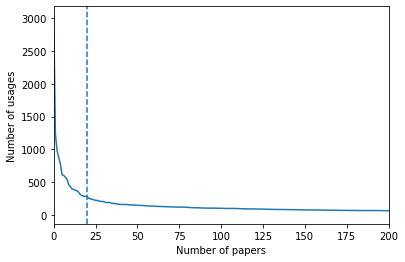

In [10]:
df_kws_counts.plot(style = "-")
plt.axvline(20, linestyle = "--")
#plt.axvline(100, linestyle = "--")
plt.xlim(0, 200)
plt.xlabel("Number of papers")
plt.ylabel("Number of usages")
plt.savefig("figures/assigned_kws_elbow.eps")

Select 20 or 100 most popular  words should be used. We will work with 20 for a while

In [11]:
tab_data = kws_counts.limit(20).collect()
tex = ""
for i, r in enumerate(tab_data):
#    print(i," ", r[0], r[1])
    tex = tex + "\t "+str(i+1) + " & " + r[0] + " & " + str(r[1]) + r" \\ " + "\n"
print(tex)

	 1 & numerical calculations & 3031 \\ 
	 2 & numerical calculations: interpretation of experiments & 1240 \\ 
	 3 & bibliography & 982 \\ 
	 4 & quantum chromodynamics & 876 \\ 
	 5 & supersymmetry & 778 \\ 
	 6 & CP: violation & 610 \\ 
	 7 & neutrino: oscillation & 602 \\ 
	 8 & Feynman graph & 573 \\ 
	 9 & electron positron: annihilation & 542 \\ 
	 10 & Feynman graph: higher-order & 459 \\ 
	 11 & effective Lagrangian & 429 \\ 
	 12 & neutrino: mixing angle & 395 \\ 
	 13 & neutrino: mass & 389 \\ 
	 14 & neutrino: solar & 373 \\ 
	 15 & perturbation theory: higher-order & 369 \\ 
	 16 & Higgs particle: mass & 341 \\ 
	 17 & electroweak interaction & 307 \\ 
	 18 & neutrino: cosmic radiation & 293 \\ 
	 19 & p p: inclusive reaction & 283 \\ 
	 20 & critical phenomena & 282 \\ 



In [12]:
# replacing some characters with _
import re
def format_kwd(kwd):
    return re.sub("[\.-/ :()]", "_", kwd)

In [13]:
selected_keywords = kws_counts.limit(20).toPandas()["K"].tolist()
selected_keywords = [format_kwd(K) for K in selected_keywords] + ["None"]
#selected_keywords

In [14]:
# from https://www.geeksforgeeks.org/python-intersection-two-lists/
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

from pyspark.sql.functions import monotonically_increasing_id

Extracting these keywords to a column

In [15]:
# returns first keyword
@udf(returnType=ArrayType(StringType()))
def list_keywords(a):
    return [format_kwd(aa["value"]) for aa in a] if a else ["None"]

@udf(returnType=ArrayType(StringType()))
def filtered_list_keywords(a):
    kws_list = [format_kwd(aa["value"]) for aa in a] if a else ["None"]
    kws_list = intersection(kws_list, selected_keywords)
    return kws_list if kws_list else ["None"]

withKeywords = short_papers.withColumn("keywords_", filtered_list_keywords(col("keywords"))) # .withColumn("id", monotonically_increasing_id())

In [16]:
# Creating dummy variables
from pyspark.sql.functions import array_contains
from pyspark.sql.functions import monotonically_increasing_id
dummy_df = withKeywords
for kw in selected_keywords:
    dummy_df = dummy_df.withColumn(
        kw.replace(".", "_"), 
        array_contains(col("keywords_"), kw).cast("int")
    )
dummy_df = dummy_df.select( ["title","number_of_pages", "citation_count", "num_refs"] + selected_keywords)
dummy_df = dummy_df.withColumn("id", monotonically_increasing_id())
dummy_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- number_of_pages: long (nullable = true)
 |-- citation_count: long (nullable = true)
 |-- num_refs: long (nullable = true)
 |-- numerical_calculations: integer (nullable = true)
 |-- numerical_calculations__interpretation_of_experiments: integer (nullable = true)
 |-- bibliography: integer (nullable = true)
 |-- quantum_chromodynamics: integer (nullable = true)
 |-- supersymmetry: integer (nullable = true)
 |-- CP__violation: integer (nullable = true)
 |-- neutrino__oscillation: integer (nullable = true)
 |-- Feynman_graph: integer (nullable = true)
 |-- electron_positron__annihilation: integer (nullable = true)
 |-- Feynman_graph__higher-order: integer (nullable = true)
 |-- effective_Lagrangian: integer (nullable = true)
 |-- neutrino__mixing_angle: integer (nullable = true)
 |-- neutrino__mass: integer (nullable = true)
 |-- neutrino__solar: integer (nullable = true)
 |-- perturbation_theory__higher-order: integer (nullable = true)
 |-- 

In [17]:
dummy_df.write.mode("overwrite").json("../data/processed/"+data_parh+"/kws/dummy/")